#Libraries


In [37]:
from google.colab import files
import io
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import numpy as np
import itertools

# plt.style.use('dark_background')

# Load data
Select the file containing the data

In [38]:
from google.colab import files
archive = files.upload()

Read CSV and load data

In [39]:
df = pd.read_csv("dengue_features_train.csv", sep=",")
df

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,300.771429,296.825714,309.7,294.5,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,299.392857,296.452857,308.5,291.9,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,297.592857,295.501429,305.5,292.4,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,297.521429,295.324286,306.1,291.9,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0


Select only the period asignated

In [40]:
#Look for those rows that has a value between 1992 and 1998 on the field 'year' 
#And make sure that the value in the 'city' field is 'sj'
data = df[df['year'].between(1992,1998)][df['city'].str.contains('sj')]
data = data.reset_index(drop=True)
data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1992,1,1992-01-01,0.125100,0.157867,0.185283,0.181367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sj,1992,2,1992-01-08,0.100833,0.073575,0.138714,0.112786,200.85,297.912857,298.121429,294.457143,300.4,296.1,18.30,81.300000,200.85,15.878571,2.300000,25.657143,7.500000,30.6,20.6,58.2
2,sj,1992,3,1992-01-15,0.222400,0.229900,0.198457,0.199414,3.12,297.338571,297.485714,294.467143,300.2,295.6,19.80,84.117143,3.12,15.832857,1.857143,25.471429,6.171429,31.1,21.7,32.3
3,sj,1992,4,1992-01-22,0.122533,0.131050,0.188843,0.168871,0.00,297.091429,297.335714,293.021429,299.5,295.6,5.11,78.291429,0.00,14.482857,2.357143,24.857143,7.442857,30.6,20.0,1.3
4,sj,1992,5,1992-01-29,NaN,0.048300,0.173671,0.191929,0.00,297.420000,297.550000,292.718571,299.3,295.5,6.50,75.220000,0.00,14.185714,2.442857,24.800000,6.585714,28.9,20.0,9.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,sj,1998,48,1998-11-26,0.050100,0.065750,0.166243,0.146757,0.00,299.232857,299.321429,295.492857,301.4,297.4,57.10,80.021429,0.00,16.867143,2.014286,26.557143,5.685714,30.0,22.8,29.8
360,sj,1998,49,1998-12-03,0.056750,0.065650,0.069186,0.052786,22.35,298.301429,298.257143,295.172857,300.4,296.5,115.77,83.024286,22.35,16.587143,1.885714,25.642857,5.942857,29.4,22.2,48.2
361,sj,1998,50,1998-12-10,0.061900,0.002633,0.213300,0.173014,152.94,298.094286,298.150000,295.540000,299.8,297.1,158.72,85.911429,152.94,16.965714,1.357143,25.814286,5.014286,28.9,22.8,97.6
362,sj,1998,51,1998-12-17,-0.082167,-0.091675,0.239900,0.170057,16.76,299.042857,299.100000,295.032857,300.9,297.6,10.20,78.668571,16.76,16.408571,1.971429,26.071429,5.542857,31.1,22.8,18.9


#Transform Data

In [41]:
data = data.loc[:, data.columns.difference(['city'])]
column = data['week_start_date']
data = data.loc[:, data.columns.difference(['week_start_date'])]
data.describe

<bound method NDFrame.describe of       ndvi_ne   ndvi_nw   ndvi_se  ...  station_precip_mm  weekofyear  year
0    0.125100  0.157867  0.185283  ...                NaN           1  1992
1    0.100833  0.073575  0.138714  ...               58.2           2  1992
2    0.222400  0.229900  0.198457  ...               32.3           3  1992
3    0.122533  0.131050  0.188843  ...                1.3           4  1992
4         NaN  0.048300  0.173671  ...                9.2           5  1992
..        ...       ...       ...  ...                ...         ...   ...
359  0.050100  0.065750  0.166243  ...               29.8          48  1998
360  0.056750  0.065650  0.069186  ...               48.2          49  1998
361  0.061900  0.002633  0.213300  ...               97.6          50  1998
362 -0.082167 -0.091675  0.239900  ...               18.9          51  1998
363  0.060567 -0.130950  0.157150  ...               29.7          52  1998

[364 rows x 22 columns]>

Lets check if we have null values in any field

In [42]:
data[data.isnull().any(axis=1)]

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear,year
0,0.12510,0.157867,0.185283,0.181367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,1992
4,NaN,0.048300,0.173671,0.191929,0.00,297.420000,297.550000,292.718571,299.3,295.5,6.50,75.220000,0.00,14.185714,2.442857,24.800000,6.585714,28.9,20.0,9.2,5,1992
6,NaN,0.130500,0.195743,0.178857,NaN,297.798571,298.057143,294.650000,300.2,295.3,20.10,82.875714,NaN,16.060000,2.200000,26.028571,6.571429,32.2,20.0,1.3,7,1992
7,NaN,0.184467,0.194614,0.203057,NaN,297.898571,298.107143,293.628571,300.1,296.3,4.40,77.295714,NaN,15.012857,2.585714,25.757143,7.385714,33.9,21.7,8.9,8,1992
8,0.10705,0.081500,0.165243,0.163057,NaN,297.472857,297.678571,292.967143,299.3,296.3,14.40,76.037143,NaN,14.381429,2.414286,25.285714,6.171429,29.4,21.7,16.0,9,1992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,NaN,0.040100,0.155483,0.141480,35.03,300.587143,300.607143,297.275714,303.0,298.8,33.83,82.332857,35.03,18.847143,2.185714,28.728571,6.985714,34.4,24.4,39.7,38,1998
352,NaN,-0.019000,0.163057,0.149200,33.26,300.712857,300.742857,296.921429,302.9,298.9,28.30,79.998571,33.26,18.418571,2.342857,28.257143,5.500000,31.7,24.4,25.0,41,1998
353,NaN,0.081550,0.186414,0.138686,25.94,300.795714,300.857143,296.612857,302.9,299.3,18.50,78.098571,25.94,18.091429,2.685714,27.757143,6.314286,31.7,23.3,15.5,42,1998
356,NaN,-0.002250,0.221229,0.169800,121.65,299.652857,299.692857,296.942857,301.7,298.5,89.50,85.120000,121.65,18.484286,1.785714,27.428571,6.457143,31.1,23.3,81.5,45,1998


Oh, there are null values D:

We are going to drop the first row as it has several fields with NaN values

In [43]:
data = data.drop(0) # Eliminate first row (contains several NaN values)
data

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear,year
1,0.100833,0.073575,0.138714,0.112786,200.85,297.912857,298.121429,294.457143,300.4,296.1,18.30,81.300000,200.85,15.878571,2.300000,25.657143,7.500000,30.6,20.6,58.2,2,1992
2,0.222400,0.229900,0.198457,0.199414,3.12,297.338571,297.485714,294.467143,300.2,295.6,19.80,84.117143,3.12,15.832857,1.857143,25.471429,6.171429,31.1,21.7,32.3,3,1992
3,0.122533,0.131050,0.188843,0.168871,0.00,297.091429,297.335714,293.021429,299.5,295.6,5.11,78.291429,0.00,14.482857,2.357143,24.857143,7.442857,30.6,20.0,1.3,4,1992
4,NaN,0.048300,0.173671,0.191929,0.00,297.420000,297.550000,292.718571,299.3,295.5,6.50,75.220000,0.00,14.185714,2.442857,24.800000,6.585714,28.9,20.0,9.2,5,1992
5,0.101600,0.084600,0.111717,0.187957,0.00,296.920000,297.128571,292.617143,300.7,294.5,16.20,77.058571,0.00,14.122857,3.400000,24.714286,7.357143,30.6,20.0,3.0,6,1992
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,0.050100,0.065750,0.166243,0.146757,0.00,299.232857,299.321429,295.492857,301.4,297.4,57.10,80.021429,0.00,16.867143,2.014286,26.557143,5.685714,30.0,22.8,29.8,48,1998
360,0.056750,0.065650,0.069186,0.052786,22.35,298.301429,298.257143,295.172857,300.4,296.5,115.77,83.024286,22.35,16.587143,1.885714,25.642857,5.942857,29.4,22.2,48.2,49,1998
361,0.061900,0.002633,0.213300,0.173014,152.94,298.094286,298.150000,295.540000,299.8,297.1,158.72,85.911429,152.94,16.965714,1.357143,25.814286,5.014286,28.9,22.8,97.6,50,1998
362,-0.082167,-0.091675,0.239900,0.170057,16.76,299.042857,299.100000,295.032857,300.9,297.6,10.20,78.668571,16.76,16.408571,1.971429,26.071429,5.542857,31.1,22.8,18.9,51,1998


Now we deal with the rest of the features that has a NaN value. What we are going to do is to substitute the NaN values in each feature for the mean corresponding to that feature.

To do that, we are going to take which features has a NaN value and then get the mean and fill the NaN values with the mean of that feature.

In [44]:
nan_features = data.columns[data.isna().any()].tolist()
nan_features

['ndvi_ne',
 'ndvi_nw',
 'ndvi_se',
 'ndvi_sw',
 'precipitation_amt_mm',
 'reanalysis_air_temp_k',
 'reanalysis_avg_temp_k',
 'reanalysis_dew_point_temp_k',
 'reanalysis_max_air_temp_k',
 'reanalysis_min_air_temp_k',
 'reanalysis_precip_amt_kg_per_m2',
 'reanalysis_relative_humidity_percent',
 'reanalysis_sat_precip_amt_mm',
 'reanalysis_specific_humidity_g_per_kg',
 'reanalysis_tdtr_k',
 'station_avg_temp_c',
 'station_diur_temp_rng_c',
 'station_max_temp_c',
 'station_min_temp_c',
 'station_precip_mm']

Now we fill the NaN values with the mean of each corresponding feature.

In [45]:
data = data.fillna(data.mean())

#Dimensionality Reduction

## Correlation among features

Correlation Matrix to drop the features that has a high value of correlation as they are going to be redundant.

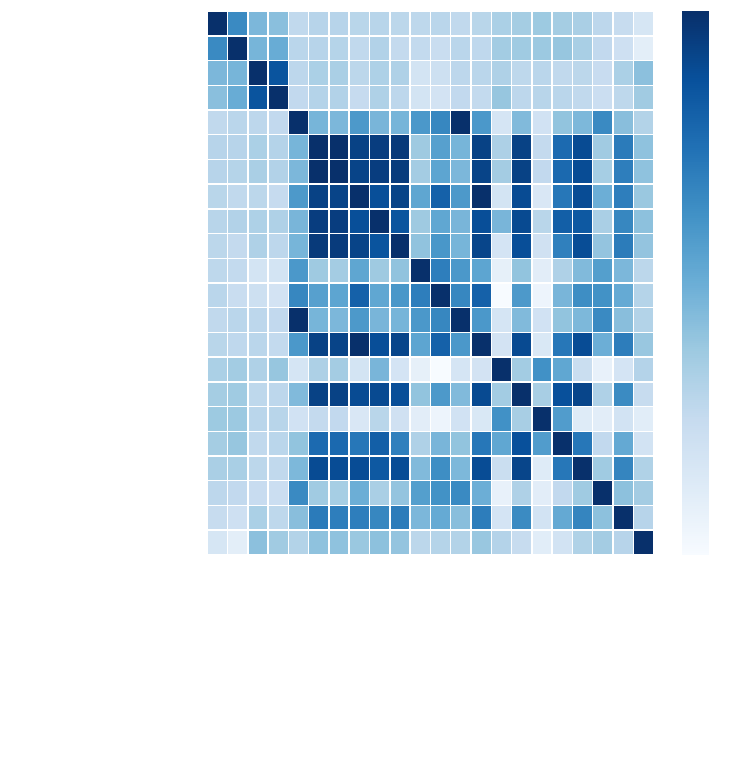

In [46]:
corrMatrix = data.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, linewidths=.5, ax=ax, cmap="Blues")
plt.show()

In [47]:
upper = corrMatrix.where(np.triu(np.ones(corrMatrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

data = data.drop(data[to_drop], axis=1)

Now we check the correlation again once we have done the feature reduction.

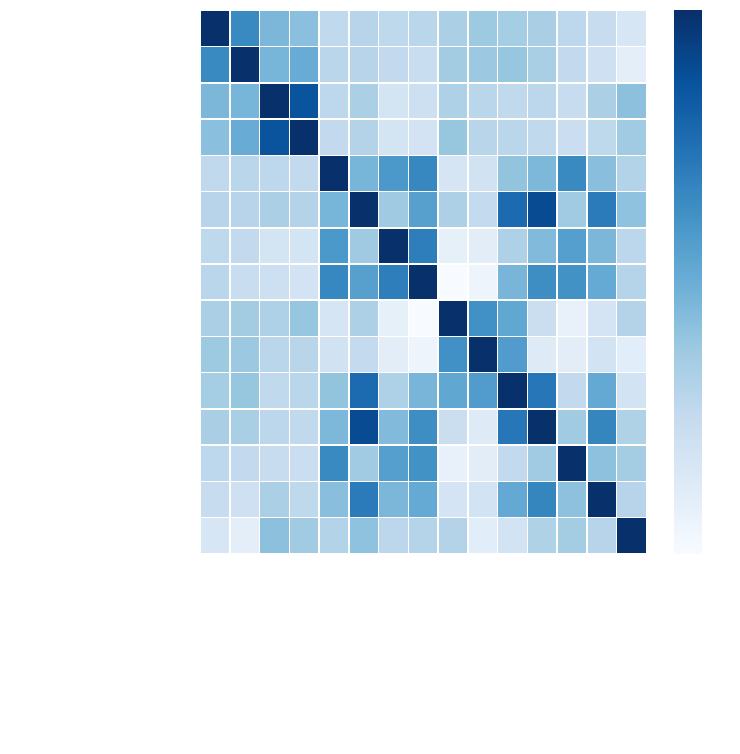

In [48]:
corrMatrix = data.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(corrMatrix, linewidths=.5, ax=ax, cmap="Blues")
plt.show()


## Principal Component Analysis

- Normalize the data

In [49]:
from sklearn import preprocessing 

scaler = preprocessing.StandardScaler()
normalized = scaler.fit_transform(data)

normalized

array([[ 0.37228656, -0.19893848, -0.72075647, ...,  1.06013032,
        -1.64105767, -1.50674161],
       [ 2.07589649,  2.25784339,  0.5029418 , ...,  0.19850719,
        -1.57427471, -1.50674161],
       [ 0.67638576,  0.7043306 ,  0.30601631, ..., -0.83277918,
        -1.50749176, -1.50674161],
       ...,
       [-0.17331644, -1.31384781,  0.80696557, ...,  2.37086203,
         1.56452403,  1.49846281],
       [-2.19223617, -2.79598441,  1.35180736, ..., -0.24727466,
         1.63130699,  1.49846281],
       [-0.19200144, -3.41322482, -0.3431422 , ...,  0.1120122 ,
         1.69808994,  1.49846281]])

- Project the data in the k dimensional space

In [50]:
# PCA Estimation
from sklearn.decomposition import PCA

estimator = PCA(n_components = 2)
X_pca = estimator.fit_transform(normalized)

- Proportion of explained variance

In [51]:
print(estimator.explained_variance_ratio_)

[0.24616948 0.16997188]


In [52]:
exp_var_cumul = np.cumsum(estimator.explained_variance_ratio_)

px.line(
    x=range(1, exp_var_cumul.shape[0] + 1),
    y=exp_var_cumul,
    labels={"x": "# Components", "y": "Explained Variance"}
)

In [53]:
fig = px.scatter(x=X_pca[:,0], y= X_pca[:,1])

for i in range(0,len(X_pca)):
     fig.add_annotation(x = X_pca[i,0], y = X_pca[i,1])
fig.show()

# Outlier Identification

##DBSCAN

### Setting parameters

- Computing similarity matrix

In [54]:
import sklearn.neighbors

distance = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matsim = distance.pairwise(normalized)

- Visualization

In [55]:
import plotly.express as px

fig = px.imshow(matsim)
fig.show()

Output hidden; open in https://colab.research.google.com to view.

- Compute distance for each point to their neighbors

In [56]:
from sklearn.neighbors import kneighbors_graph

minPts=60

A = kneighbors_graph(normalized, minPts, include_self=False)
Ar = A.toarray()

seq = []
for i,s in enumerate(normalized):
    for j in range(len(normalized)):
        if Ar[i][j] != 0:
            seq.append(matsim[i][j])
            
seq.sort()

In [57]:
fig = px.line(x=np.arange(0, len(seq), 1), y=seq)
fig.show()

In [58]:
from sklearn.cluster import DBSCAN

results = []
for eps in np.arange(3, 9, 0.2):
  db = DBSCAN(eps, min_samples=minPts).fit(normalized)
  core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
  core_samples_mask[db.core_sample_indices_] = True
  labels = db.labels_
  n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
  n_outliers = list(labels).count(-1)
  #print ("%6.2f, %d, %d" % (eps, n_clusters_, n_outliers))
  results.append([eps, n_clusters_, n_outliers])

#print results
from tabulate import tabulate
print(tabulate(results, headers = ("eps", "clusters", "outliers")))

  eps    clusters    outliers
-----  ----------  ----------
  3             1         191
  3.2           1         118
  3.4           1          59
  3.6           1          37
  3.8           1          21
  4             1          15
  4.2           1          10
  4.4           1           5
  4.6           1           2
  4.8           1           2
  5             1           2
  5.2           1           2
  5.4           1           2
  5.6           1           2
  5.8           1           2
  6             1           2
  6.2           1           2
  6.4           1           2
  6.6           1           2
  6.8           1           2
  7             1           2
  7.2           1           2
  7.4           1           2
  7.6           1           1
  7.8           1           1
  8             1           1
  8.2           1           1
  8.4           1           1
  8.6           1           1
  8.8           1           1


### Execution

In [59]:
db = DBSCAN(eps=4.1, min_samples=minPts).fit(normalized)
labels = db.labels_
labels

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [60]:
#plotting orginal points with color related to label
import plotly.express as px
fig = px.scatter(x=X_pca[:,0], y= X_pca[:,1], color = labels)

for i in range(0,len(X_pca)):
     fig.add_annotation(x = X_pca[i,0], y = X_pca[i,1])
fig.show()

In [61]:
data['dbscan'] = labels
data[data['dbscan'] == -1]

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_tdtr_k,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,weekofyear,year,dbscan
20,0.102400,0.068600,0.062383,0.057400,71.85,298.408571,570.50,85.647143,2.714286,6.771429,32.8,23.3,22.1,21,1992,-1
45,0.118000,0.142200,0.089450,0.066800,40.06,299.041429,31.72,79.012857,2.414286,6.842857,31.7,22.8,161.0,46,1992,-1
100,0.357267,-0.009500,0.127340,0.089414,6.09,298.627143,25.70,80.465714,2.014286,8.342857,33.3,21.1,5.5,48,1993,-1
102,-0.290200,-0.067667,0.168286,0.080000,14.82,298.565714,28.60,76.854286,2.457143,7.857143,31.1,21.1,7.7,50,1993,-1
111,0.363300,0.241850,0.247386,0.283414,0.00,297.774286,7.20,72.885714,2.285714,7.157143,30.6,21.1,9.7,7,1994,-1
169,0.198620,0.259575,0.245150,0.305457,0.00,296.887143,4.60,67.364286,4.000000,7.757143,30.0,20.0,4.1,13,1995,-1
245,0.074268,0.028450,0.150429,0.107817,243.55,299.482857,151.70,85.690000,1.828571,5.828571,31.7,22.8,305.9,38,1996,-1
253,-0.030067,0.088100,0.075057,0.098000,34.32,298.245714,219.90,83.640000,1.800000,6.028571,30.0,22.2,25.0,46,1996,-1
256,-0.117100,-0.010167,0.260271,0.230843,0.00,297.642857,20.57,75.292857,1.900000,5.057143,28.3,21.7,19.6,49,1996,-1
314,-0.016150,-0.008225,0.204714,0.198571,106.97,297.612857,53.20,84.694286,1.885714,5.857143,29.4,20.6,152.4,3,1998,-1


In [62]:
data = data[data['dbscan'] != -1]

data.info

<bound method DataFrame.info of       ndvi_ne   ndvi_nw   ndvi_se  ...  weekofyear  year  dbscan
1    0.100833  0.073575  0.138714  ...           2  1992       0
2    0.222400  0.229900  0.198457  ...           3  1992       0
3    0.122533  0.131050  0.188843  ...           4  1992       0
4    0.074268  0.048300  0.173671  ...           5  1992       0
5    0.101600  0.084600  0.111717  ...           6  1992       0
..        ...       ...       ...  ...         ...   ...     ...
358  0.074268  0.086233  0.253743  ...          47  1998       0
359  0.050100  0.065750  0.166243  ...          48  1998       0
360  0.056750  0.065650  0.069186  ...          49  1998       0
362 -0.082167 -0.091675  0.239900  ...          51  1998       0
363  0.060567 -0.130950  0.157150  ...          52  1998       0

[351 rows x 16 columns]>

# Clustering by K-Means

# Hierarchical Clustering Algorithm

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: ClusterWarning:

scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix



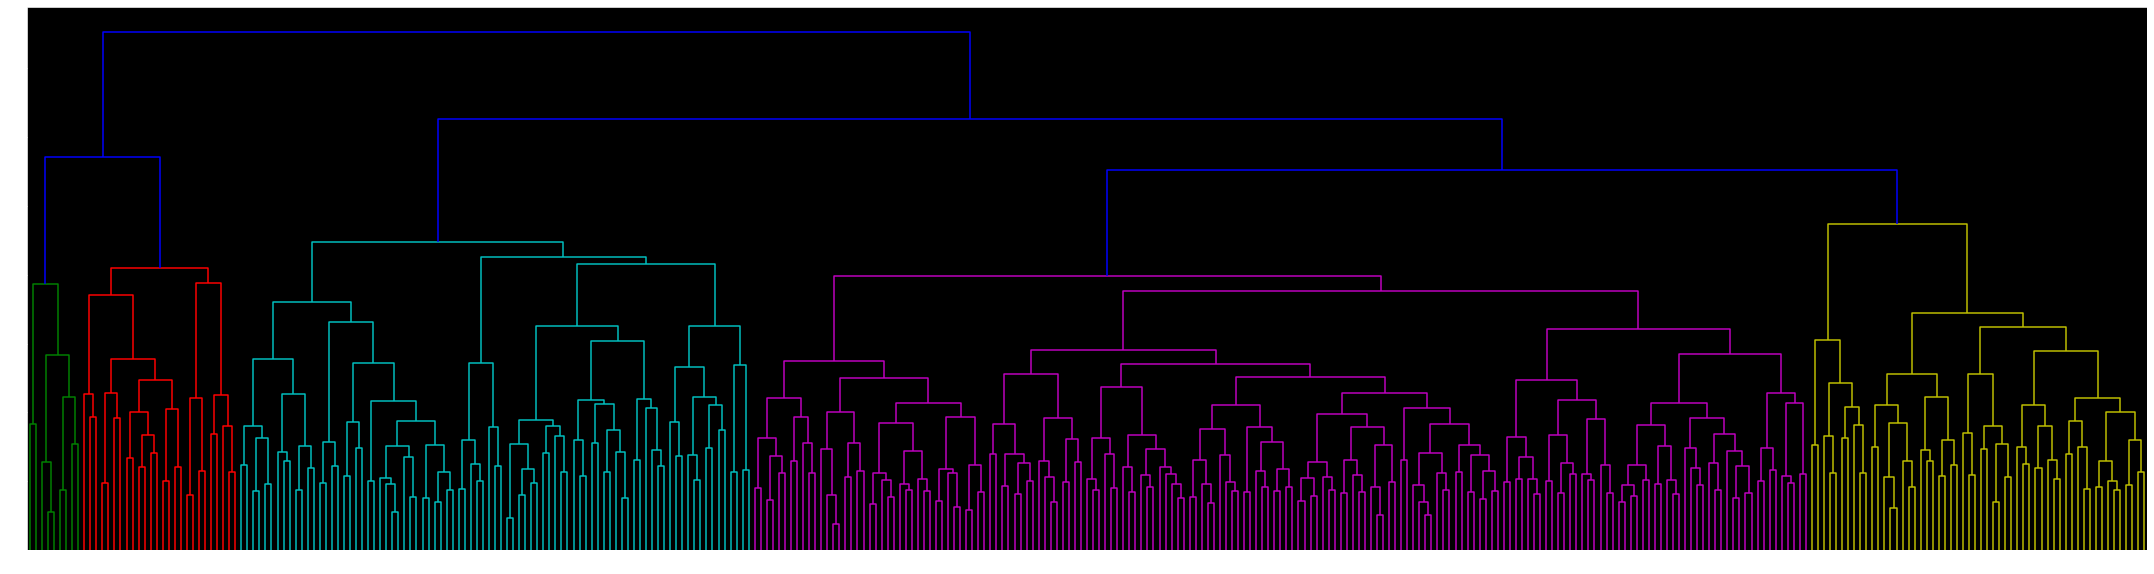

In [66]:
from sklearn import preprocessing 

scaler = preprocessing.StandardScaler()
normalized = scaler.fit_transform(data)

normalized

import sklearn.neighbors
d = sklearn.neighbors.DistanceMetric.get_metric('euclidean')
matsim = d.pairwise(normalized)

from scipy import cluster
clusters = cluster.hierarchy.linkage(matsim, method = 'complete')

fig = plt.figure(figsize = (38, 10))
dendogram = cluster.hierarchy.dendrogram(clusters, color_threshold=50)


In [64]:
labels = cluster.hierarchy.fcluster(clusters, 50, criterion = 'distance')

labels

array([2, 3, 3, 3, 3, 4, 3, 4, 3, 4, 4, 4, 4, 3, 5, 4, 3, 3, 4, 2, 5, 5,
       4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 1, 4, 4, 4, 5,
       5, 5, 4, 4, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 4, 4, 4, 3, 4,
       4, 5, 5, 4, 5, 5, 4, 4, 5, 4, 4, 5, 4, 5, 4, 4, 4, 4, 4, 5, 4, 4,
       5, 4, 4, 4, 4, 4, 3, 5, 2, 5, 5, 4, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3,
       1, 3, 3, 4, 4, 3, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4, 5, 4, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 5, 4, 4, 5, 1, 3, 3,
       3, 4, 1, 3, 4, 3, 4, 4, 1, 1, 4, 3, 3, 3, 4, 2, 2, 2, 2, 4, 4, 5,
       1, 4, 4, 5, 5, 4, 4, 5, 4, 5, 2, 2, 5, 2, 4, 4, 4, 5, 4, 4, 4, 4,
       3, 4, 3, 2, 4, 4, 3, 3, 3, 4, 4, 2, 3, 4, 4, 3, 4, 4, 4, 4, 3, 3,
       3, 4, 4, 4, 4, 5, 4, 4, 4, 5, 4, 5, 5, 4, 2, 5, 5, 5, 4, 4, 4, 4,
       3, 4, 5, 2, 5, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 4, 4, 4, 4, 4, 4,
       4, 5, 4, 4, 5, 2, 5, 5, 4, 4, 5, 2, 5, 3, 3,

In [65]:
# tratamos el cluster -1 como cluster de outliers
from sklearn import metrics
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(normalized, labels))

Estimated number of clusters: 5
Silhouette Coefficient: 0.074


- ~Correlaccion para eliminar las caracteristicas redundantes~
- ~NaN se sustituyen por la media (o el forward field [algo asi])~
- ~Normalizar~
- ~Hacer PCA~

##DUDAS

- ~Preguntar por eliminacion de variales muy correladas (quitamos ahora mismo valores > 0.9)~
- ~Preguntar por normalizacion (valores superiores a 1 e inferiores a 0)
REVISAR CUADERNO DE K-MEANS~

## Siguiente

- StandardScaler no normaliza entre 0 y 1, está bien. Para ponerlo entre 0 y 1 usar MinMaxScaler
- Aplicar algoritmo de clustering hasta el final y ver si el resultado esta bien o mal: K-Means o DbScan.